In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
!pip install tensorflow==1.8.0
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
!unzip /content/WISDM_ar_v1.1_raw.zip

Archive:  /content/WISDM_ar_v1.1_raw.zip
  inflating: WISDM_ar_v1.1_raw.txt   


In [ ]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [ ]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


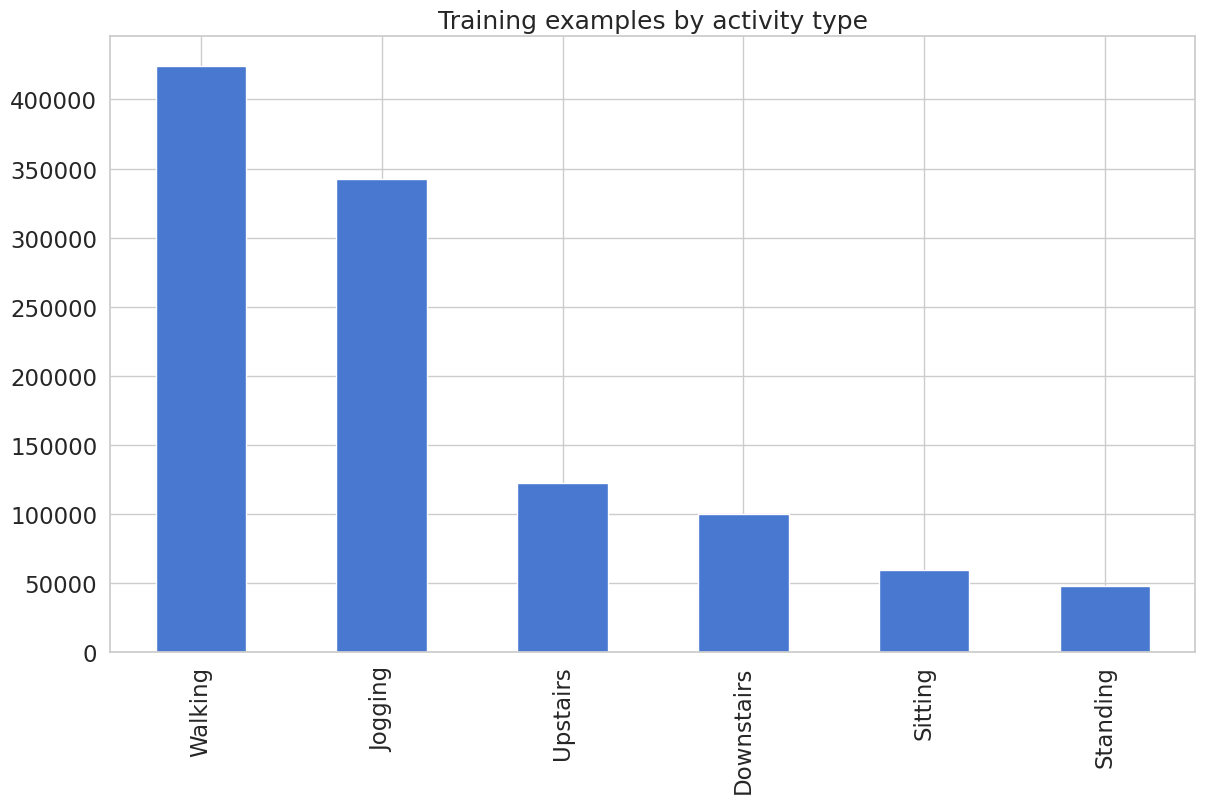

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

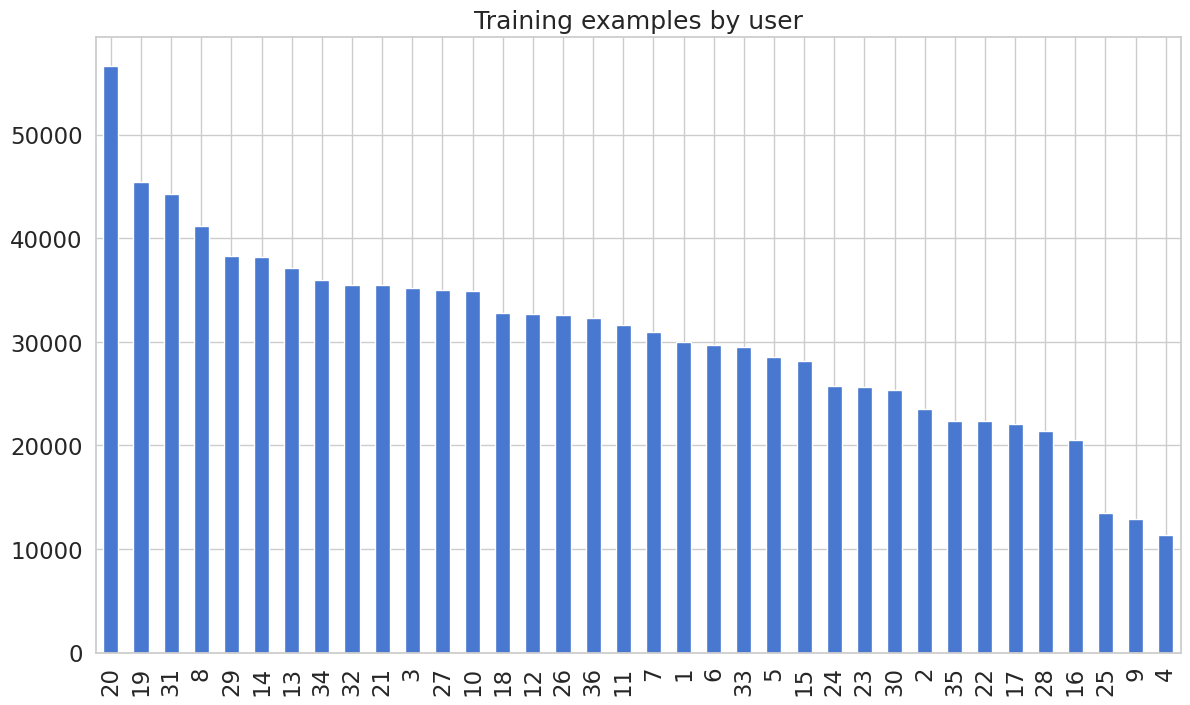

In [ ]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

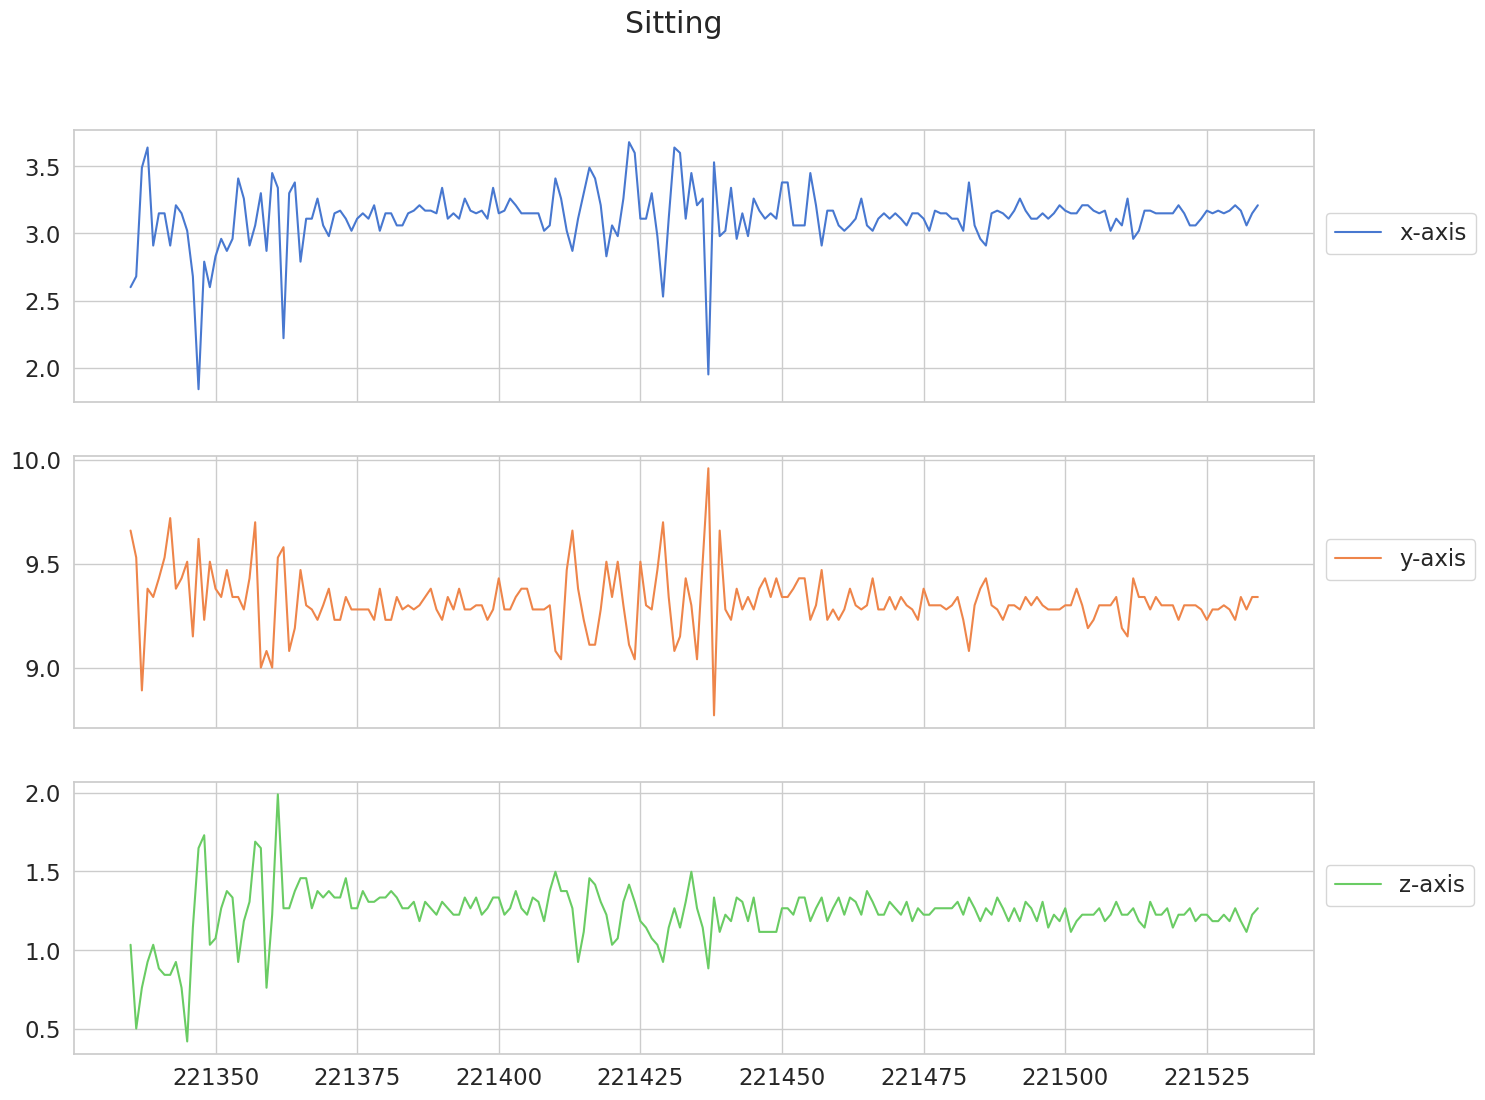

In [ ]:
plot_activity("Sitting", df)

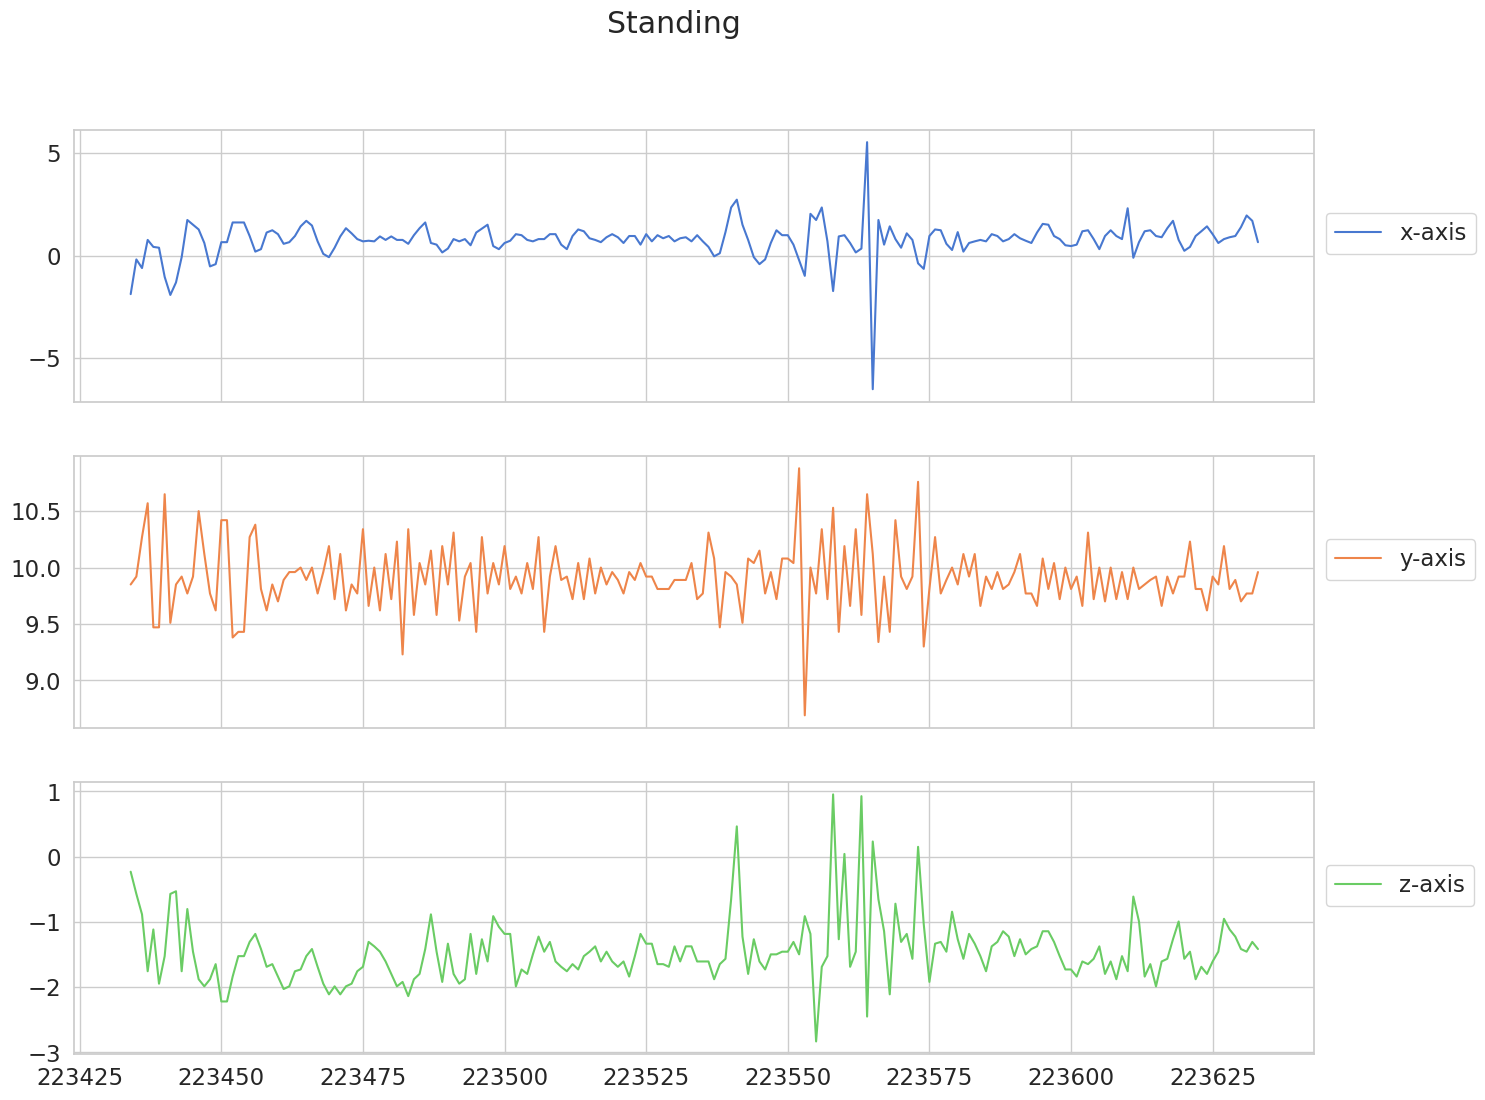

In [ ]:
plot_activity("Standing", df)

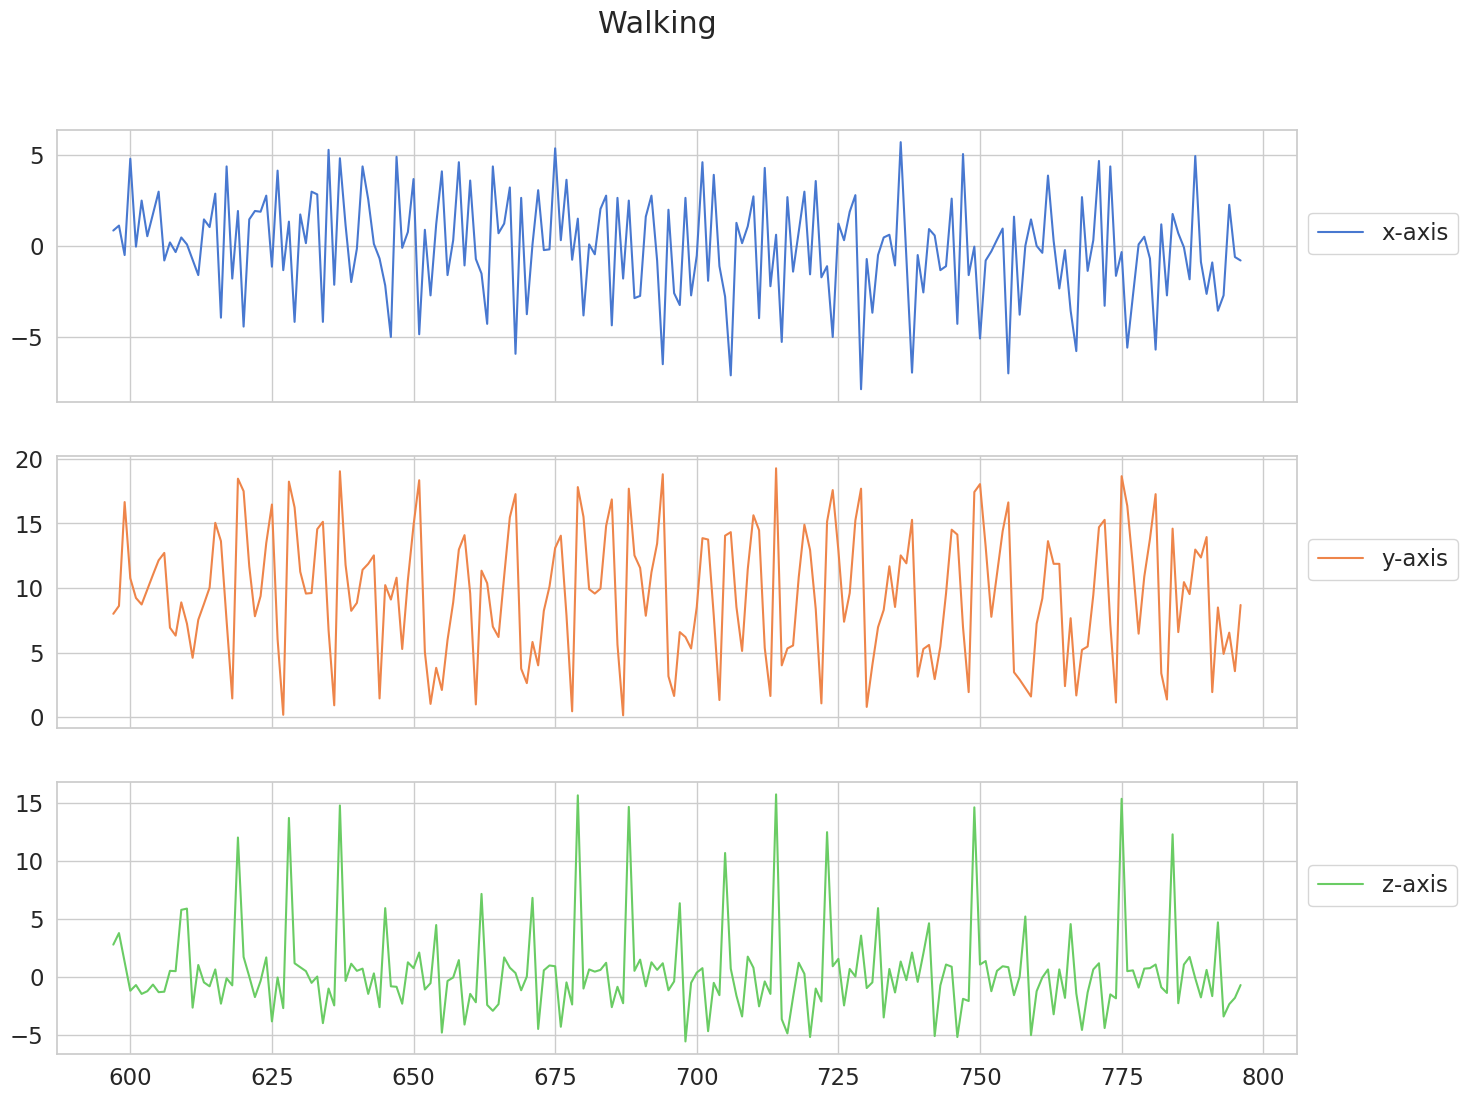

In [ ]:
plot_activity("Walking", df)

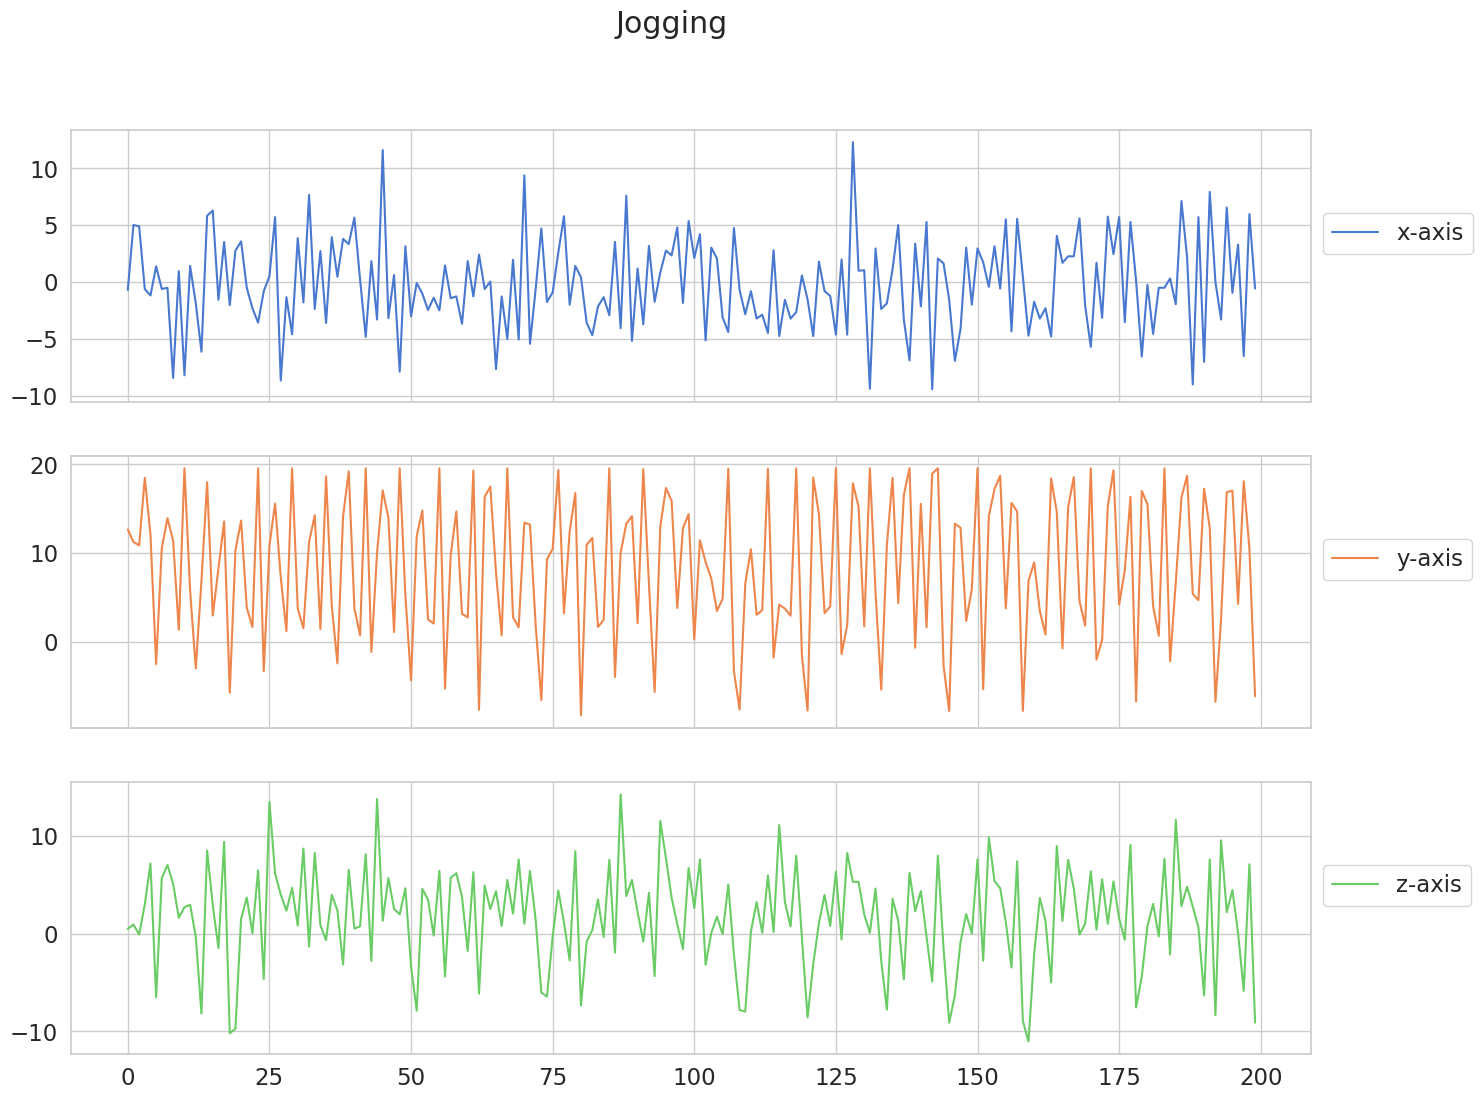

In [ ]:
plot_activity("Jogging", df)

In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

<ipython-input-53-6ae5fa4a6d8a>:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
<ipython-input-53-6ae5fa4a6d8a>:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]


In [ ]:
np.array(segments).shape

(54901, 3, 200)

In [ ]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
reshaped_segments.shape

(54901, 200, 3)

In [ ]:
labels[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
len(X_train)

43920

In [ ]:
len(X_test)

10981

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.compat.v1.Variable(tf.compat.v1.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.compat.v1.Variable(tf.compat.v1.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.compat.v1.Variable(tf.compat.v1.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.compat.v1.Variable(tf.compat.v1.random_normal([N_CLASSES]))
    }

    X = tf.compat.v1.transpose(inputs, [1, 0, 2])
    X = tf.compat.v1.reshape(X, [-1, N_FEATURES])
    hidden = tf.compat.v1.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.compat.v1.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)

    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.compat.v1.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.compat.v1.matmul(lstm_last_output, W['output']) + biases['output']

In [ ]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])

In [ ]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.compat.v1.nn.softmax(pred_Y, name="y_")

<ipython-input-63-ca386c5b80c8>:17: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]


In [ ]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.compat.v1.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())

loss = tf.compat.v1.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [ ]:
LEARNING_RATE = 0.0025

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.compat.v1.equal(tf.compat.v1.argmax(pred_softmax, 1), tf.compat.v1.argmax(Y, 1))
accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(correct_pred, dtype=tf.float32))

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
saver = tf.compat.v1.train.Saver()

history = dict(train_loss=[],
                     train_acc=[],
                     test_loss=[],
                     test_acc=[])

sess=tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')

predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8057553768157959 loss: 1.2273916006088257

final results: accuracy: 0.8057553768157959 loss: 1.2273916006088257


In [ ]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.compat.v1.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

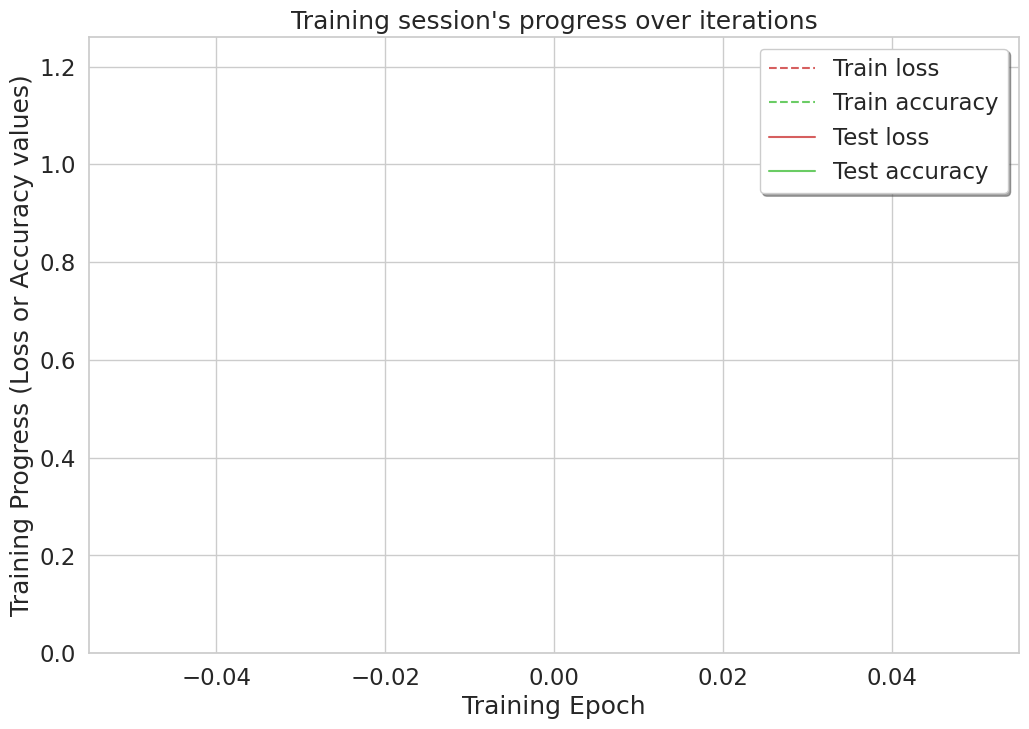

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [ ]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

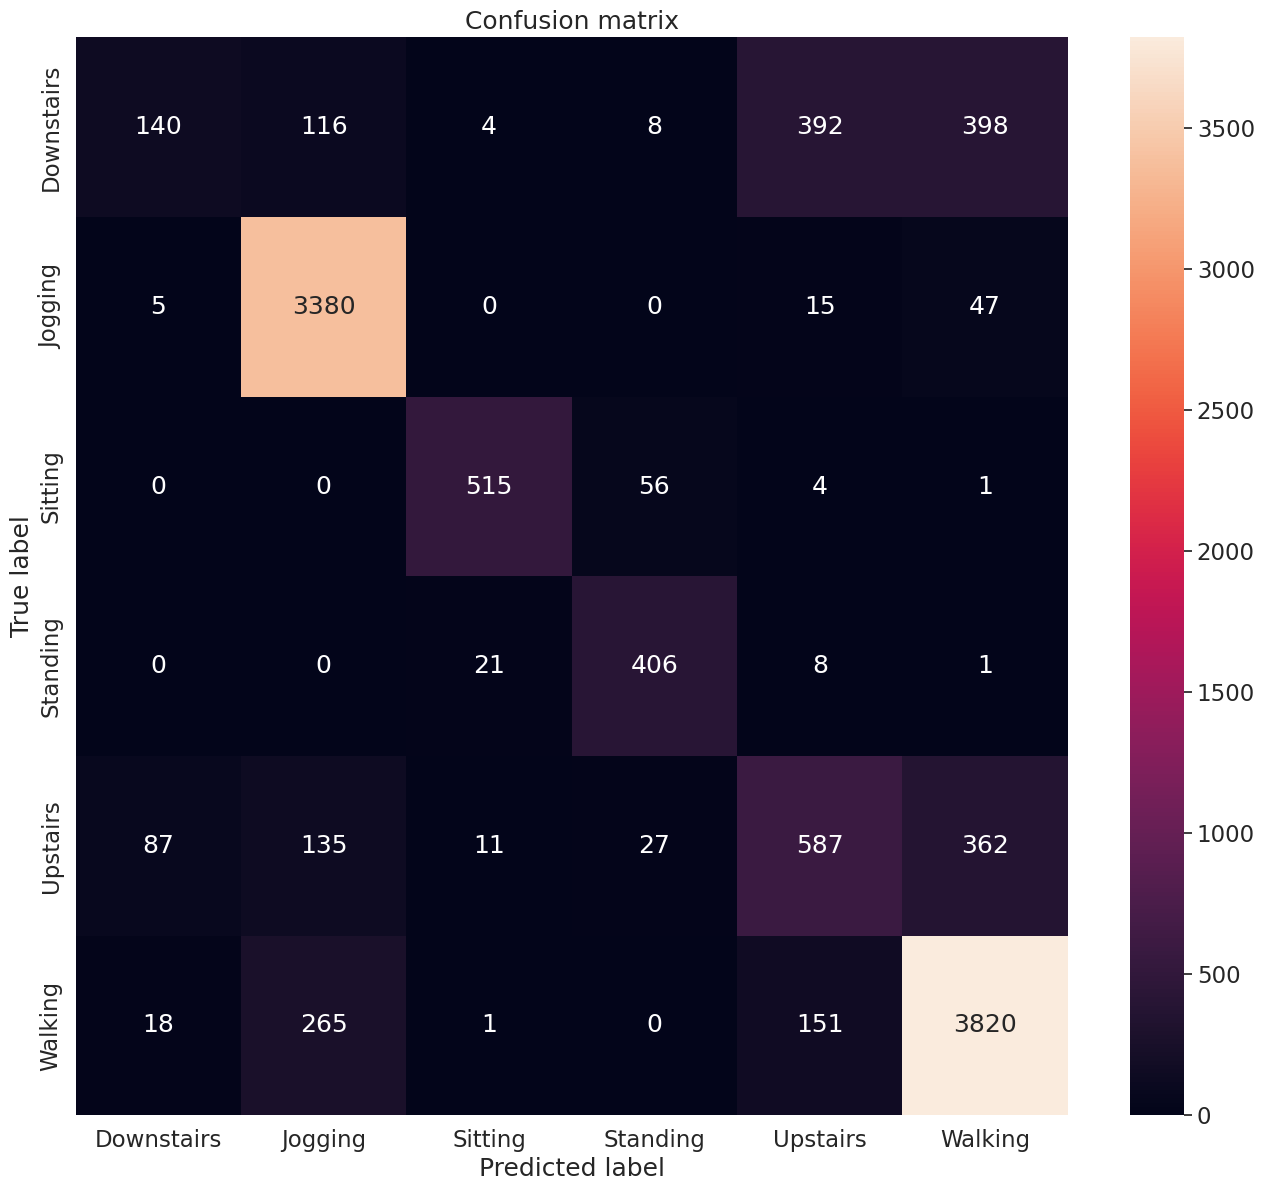

In [ ]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
# import os
# import tensorflow as tf

# trained_checkpoint_prefix = '/content/checkpoint/har.ckpt'
# export_dir = os.path.join('/content/data', '0')

# graph = tf.Graph()
# with tf.compat.v1.Session(graph=graph) as sess:
#     # Restore from checkpoint
#     loader = tf.compat.v1.train.import_meta_graph(trained_checkpoint_prefix + '.meta')
#     loader.restore(sess, trained_checkpoint_prefix)

#     # Export checkpoint to SavedModel
#     builder = tf.compat.v1.saved_model.builder.SavedModelBuilder(export_dir)
#     builder.add_meta_graph_and_variables(sess,
#                                          [tf.saved_model.TRAINING, tf.saved_model.SERVING],
#                                          strip_default_attrs=True)
#     builder.save()

In [ ]:
!pip install tensorflow==1.8.0
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path,
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0",
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")